## I. Import packages

In [1]:
from __future__ import print_function
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
import time

from keras.applications import vgg16
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Set backend configurations

In [2]:
K.set_image_dim_ordering('tf')

print(K.backend())
print(K.image_dim_ordering())

tensorflow
tf


## II. Parameters and hyperparameters

In [3]:
base_image_path = 'Images/Content/katrina.jpeg'
style_reference_image_path = 'Images/Style/mona_lisa.jpg'
result_dir = 'Images/Results'
result_prefix = 'katrina'
iterations = 6

In [4]:
# Weights of the different loss components
total_variation_weight = 0.04
style_weight = 1.0
content_weight = 1.0

In [5]:
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## III. Data preparation

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [7]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]   # 'BGR'->'RGB'
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Obtain tensor representations of the images

In [8]:
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

input_tensor = K.concatenate([base_image, style_reference_image, combination_image], axis=0)

## IV. Define loss

### Gram matrix of an image tensor (feature-wise outer product)

In [9]:
def gram_matrix(x):
    assert K.ndim(x) == 3    
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

### "Style loss" is based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image

In [10]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

### "Content loss"

In [11]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

### "Total variation loss" is designed to keep the generated image locally coherent

In [12]:
def total_variation_loss(x):
    assert K.ndim(x) == 4    
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### Build the VGG16 network (pretrained on ImageNet) with the 3 images as input

In [13]:
model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

### Calculate the loss

In [14]:
loss = K.variable(0.)
layer_features = outputs_dict['block4_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features, combination_features)

feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)

## V. Obtain gradients of loss w.r.t. generated image

In [15]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):   
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

### This Evaluator class makes it possible to compute loss and gradients in one pass while retrieving them via two separate functions, "loss" and "grads". This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [16]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## VI. Run L-BFGS

### Plot the original images

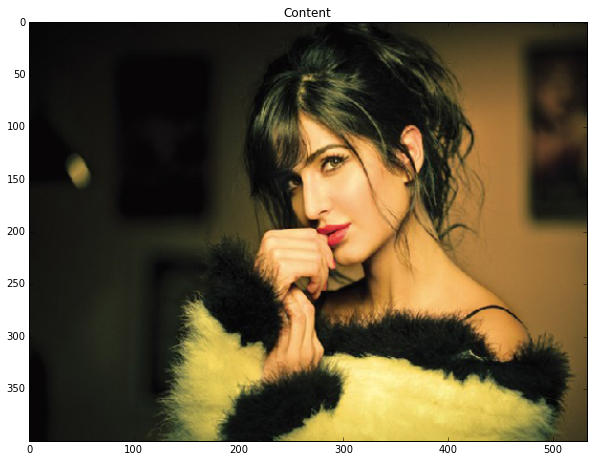

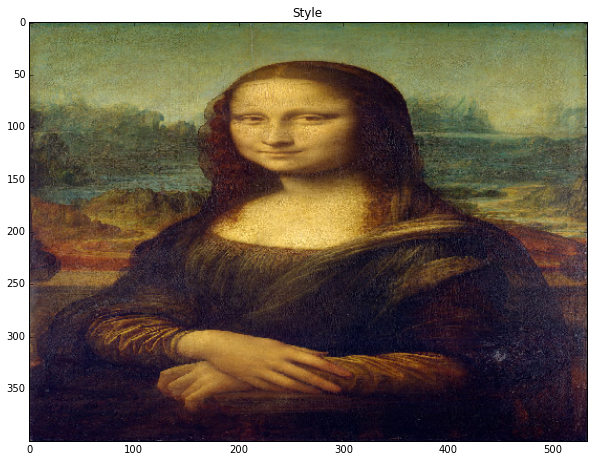

In [17]:
plt.figure(figsize = (10,10))
plt.imshow(load_img(base_image_path, target_size=(img_nrows, img_ncols)))
plt.title('Content')
plt.figure(figsize = (10,10))
plt.imshow(load_img(style_reference_image_path, target_size=(img_nrows, img_ncols)))
plt.title('Style')

### Run L-BFGS, and plot and save the generated images



Start of iteration 1
Current loss value: 1.59216e+10
Image saved as:  Images/Results katrina_at_iteration_1.png
Iteration 1 completed in 380s


Start of iteration 2
Current loss value: 9.39973e+09
Image saved as:  Images/Results katrina_at_iteration_2.png
Iteration 2 completed in 396s


Start of iteration 3
Current loss value: 6.87358e+09
Image saved as:  Images/Results katrina_at_iteration_3.png
Iteration 3 completed in 395s


Start of iteration 4
Current loss value: 5.68395e+09
Image saved as:  Images/Results katrina_at_iteration_4.png
Iteration 4 completed in 395s


Start of iteration 5
Current loss value: 4.94632e+09
Image saved as:  Images/Results katrina_at_iteration_5.png
Iteration 5 completed in 391s


Start of iteration 6
Current loss value: 4.48428e+09
Image saved as:  Images/Results katrina_at_iteration_6.png
Iteration 6 completed in 385s


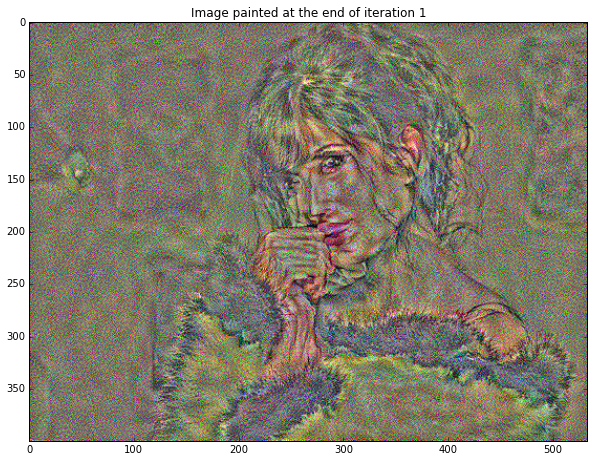

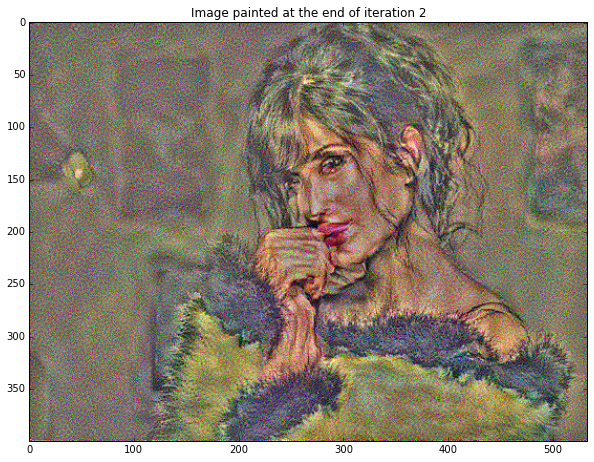

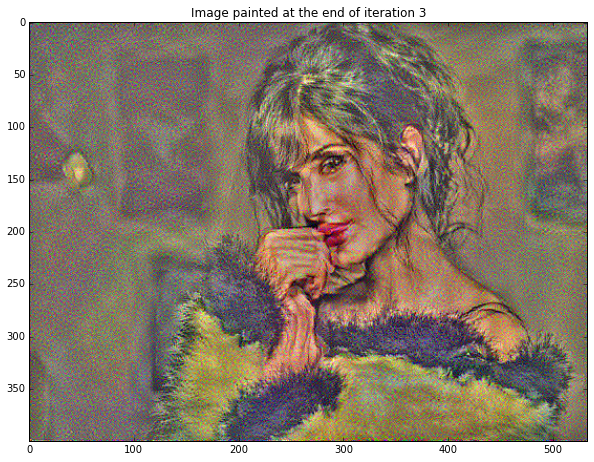

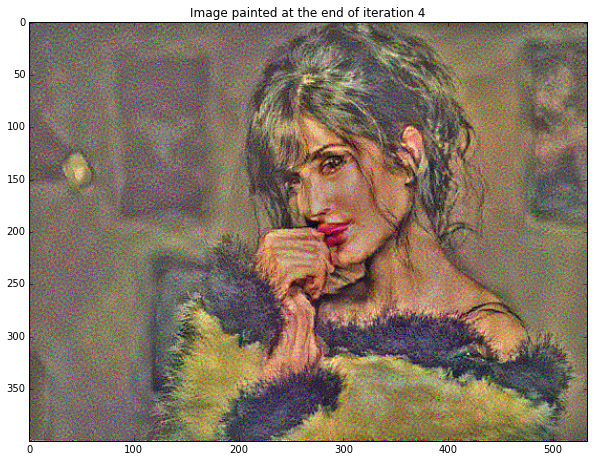

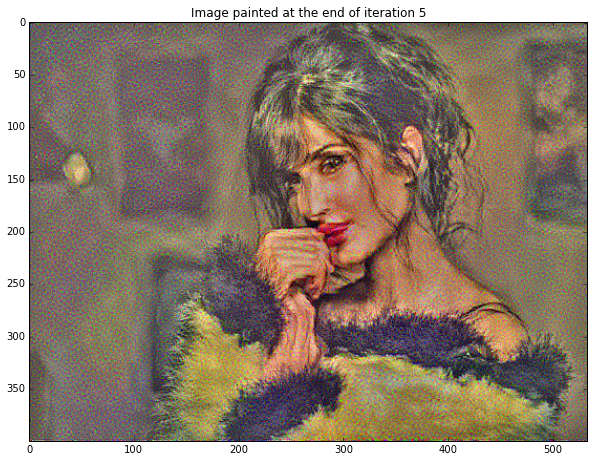

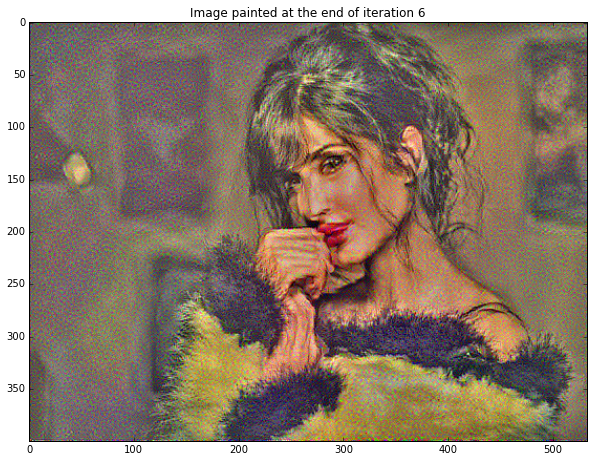

In [18]:
x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.

for i in range(iterations):
    print('\n\nStart of iteration', i+1)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=30)
    print('Current loss value:', min_val)
    # Plot and save current generated image
    img = deprocess_image(x.copy())
    fig = plt.figure(figsize = (10,10))
    plt.imshow(img)
    plt.title('Image painted at the end of iteration %d' %(i+1))
    fname = result_prefix + '_at_iteration_%d.png' % (i+1)
    fig.savefig(os.path.join(result_dir, fname))
    print('Image saved as: ', result_dir, fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))